## IV. Methodology

### 4.1 Dataset Preparation
* Load the clean EEG, EOG, and EMG data from the EEGDenoiseNet dataset in .npy format.
* Randomly select a clean EEG segment (2-second duration) from the dataset.
* Randomly select an EOG or EMG artifact segment from the respective dataset.
### 4.2 SNR Generation
* Determine the desired range of SNR values to evaluate for both ocular and myogenic artifacts. For example, consider the ranges mentioned in the paper: ocular artifacts (-7 to 2 dB) and myogenic artifacts (-7 to 4 dB).
* Randomly select an SNR value from the respective range for each contaminated signal.
### 4.3 Contaminated Signal Generation
For each selected clean EEG segment:
* Randomly select an artifact type (EOG or EMG).
* Randomly select an artifact segment from the chosen type.
* Calculate the contaminated signal using the formula: contaminated_signal = clean_eeg + λ * artifact_segment.
* Adjust the value of λ based on the randomly selected SNR value.
### 4.4 Denoising Methods
#### 4.4.1 Independent Component Analysis
* Apply ICA to the contaminated EEG signal to extract independent components.
* Identify the components representing the EEG signal.
* Reconstruct the denoised EEG signal using the selected components.
* Measure the processing time and SNR of the denoised signal.
#### 4.4.2 Empirical Mode Decomposition
* Apply EMD to the contaminated EEG signal to decompose it into intrinsic mode functions (IMFs).
* Analyze the IMFs to identify and remove artifacts or noise components.
* Reconstruct the denoised EEG signal using the remaining IMFs.
* Measure the processing time and SNR of the denoised signal.
### 4.5 Evaluation
* Calculate the SNR of the denoised EEG signals using appropriate metrics such as the ratio of signal power to noise power.
* Compare the SNR performance and processing time of ICA and EMD for denoising the EEG signals.
* Analyze the results and draw conclusions regarding the denoising effectiveness and efficiency of each method.

### 4.1 Dataset Preparation

In [1]:
import numpy as np
eeg = np.load('EEGDenoiseNet/EEG_all_epochs.npy')
print(f"------EEG-----\nSize: {eeg.size}\nRow count: {len(eeg)}\nColumn count: {len(eeg[0])}\nFirst Column: {eeg[:, 0]}\n\n")

emg = np.load('EEGDenoiseNet/EMG_all_epochs.npy')
print(f"------EMG(Heart)-----\nSize: {emg.size}\nRow count: {len(emg)}\nColumn count: {len(emg[0])}\nFirst Column: {emg[:, 0]}\n\n")

eog = np.load('EEGDenoiseNet/EOG_all_epochs.npy')
print(f"------EOG(Ocular)-----\nSize: {eog.size}\nRow count: {len(eog)}\nColumn count: {len(eog[0])}\nFirst Column: {eog[:, 0]}")

------EEG-----
Size: 2311168
Row count: 4514
Column count: 512
First Column: [184.5070843  171.96198926 229.56731921 ... 317.59704985 262.89154388
 216.07429779]


------EMG(Heart)-----
Size: 2866176
Row count: 5598
Column count: 512
First Column: [20245.96672667 23595.64263225 34991.76745427 ...  1490.61150022
   -38.705385    1260.54203952]


------EOG(Ocular)-----
Size: 1740800
Row count: 3400
Column count: 512
First Column: [  7.30828446  -1.68701752  12.4808031  ...   6.81209745 298.19922839
 -44.54226777]


In [2]:
import matplotlib.pyplot as plt

def plot_random_row(dataset, title:str):
    num_rows, num_columns = dataset.shape
    sampling_rate = 256  # Hz
    duration = 2  # seconds
    time = np.arange(0, duration, 1/sampling_rate)

    #----PLOT RANDOM ROW AS SAMPLE-----
    random_row_index = np.random.randint(num_rows) #produce random index or number
    random_row = dataset[random_row_index] #extract row of that corresponding index
    plt.plot(time, random_row)
    plt.title(f'{title} Dataset Row #{random_row_index} (random)')
    return plt.show()

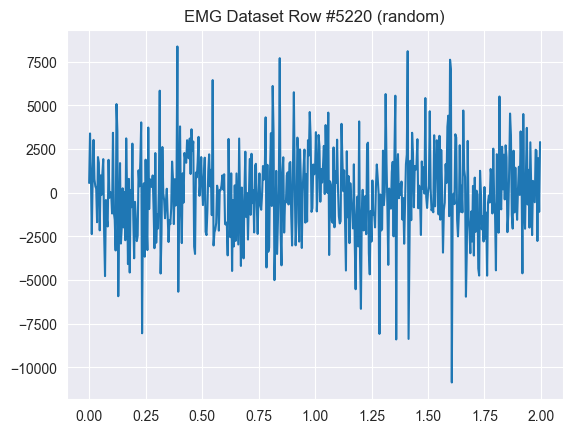

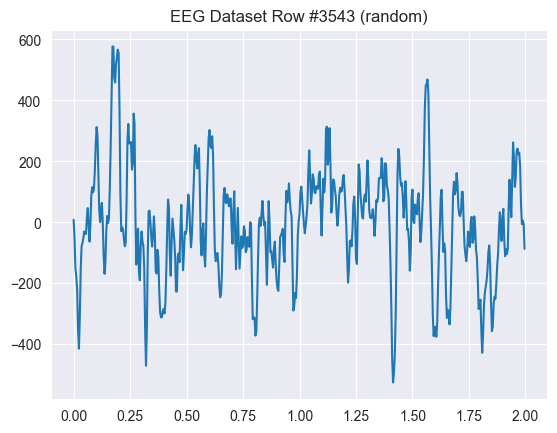

In [3]:
plot_random_row(emg,'EMG')
plot_random_row(eeg,'EEG')

### 4.2 SNR Generation

* Randomly select an SNR value from the respective range for each contaminated signal.

Ocular artifacts: [-7 to 2]
Mygoenic artifact: [-7 to 4]

What I did for this part is every time I create a contaminated EEG signal, a random SNR value is chosen. I did not pick specific SNR values anymore as increasing or decreasing SNR value doesn't necessarily mean it's more complex.

### 4.3 Contaminated Signal Generation

In [4]:
print(len(eeg[1]))
print(eeg[1][0])

512
171.96198926000247


In [5]:
# #RMS
# #g is 1 sample of EEG data. n is the 512 columns
def rms(eeg_index):
    #n = number of samples
    #summation of g^2
    sum=0
    for i in range(512):
        sum+=(eeg[eeg_index][i])**2
    return ((1/512)*sum)**0.5


# #SNR
# import math
# def snr()
#     z = rms()
#     math.log10(z)

**WHAT'S WRONG?**

* Delta should be used in the code instead of SNR.
* Delta should be adjusted based on the SNR value you want
* It should be: ```contaminated_eeg_sample = clean_eeg_sample + delta*eog_artifact```

ADD CODE TO DETERMINE THE DELTA BASED ON THE RANDOMLY GENERATED SNR VALUE.

$$\text{SNR} = 10log\frac{RMS(x)}{RMS(\lambda\times n)}$$


$$\frac{SNR}{10} = log\frac{RMS(x)}{RMS(\lambda\times n)}$$

$$SNR=10\log\frac{\text{RMS(signal)}}{RMS(noise)}$$

In [6]:
## ATTEMPT 2 OF FUNCTION GENERATE_CONTAMINATED_EEG_DATA | WITH CONTAMINATION INDICES

def generate_contaminated_eeg_data(clean_eeg_data, artifacts, num_samples, artifact_type:str):
    num_clean_eeg_samples = clean_eeg_data.shape[0]
    num_artifacts = artifacts.shape[0]

    contaminated_eeg_data = []
    contamination_indices = []
    snr_values = []
    if artifact_type=='eog':
        max_snr = 2+1
    elif artifact_type=='emg':
        max_snr=4+1

    for _ in range(num_samples):
        snr = np.random.randint(-7, max_snr)
        clean_eeg_index = np.random.randint(0, num_clean_eeg_samples)
        artifact_index = np.random.randint(0, num_artifacts)

        clean_eeg_sample = clean_eeg_data[clean_eeg_index]
        eog_artifact = artifacts[artifact_index]
        contaminated_eeg_sample = clean_eeg_sample + snr*eog_artifact

        contaminated_eeg_data.append(contaminated_eeg_sample)
        contamination_indices.append((clean_eeg_index, artifact_index))
        snr_values.append(snr)

    return np.array(contaminated_eeg_data), contamination_indices,snr_values

In [7]:
num_samples = 1000  # Specify the number of contaminated EEG data samples to generate
contaminated_eeg_data, contamination_indices,snr_values = generate_contaminated_eeg_data(eeg, eog, num_samples,artifact_type='eog')

# Verify the shape of the generated contaminated EEG data
print("Shape of contaminated EEG data:", contaminated_eeg_data.shape)

Shape of contaminated EEG data: (1000, 512)


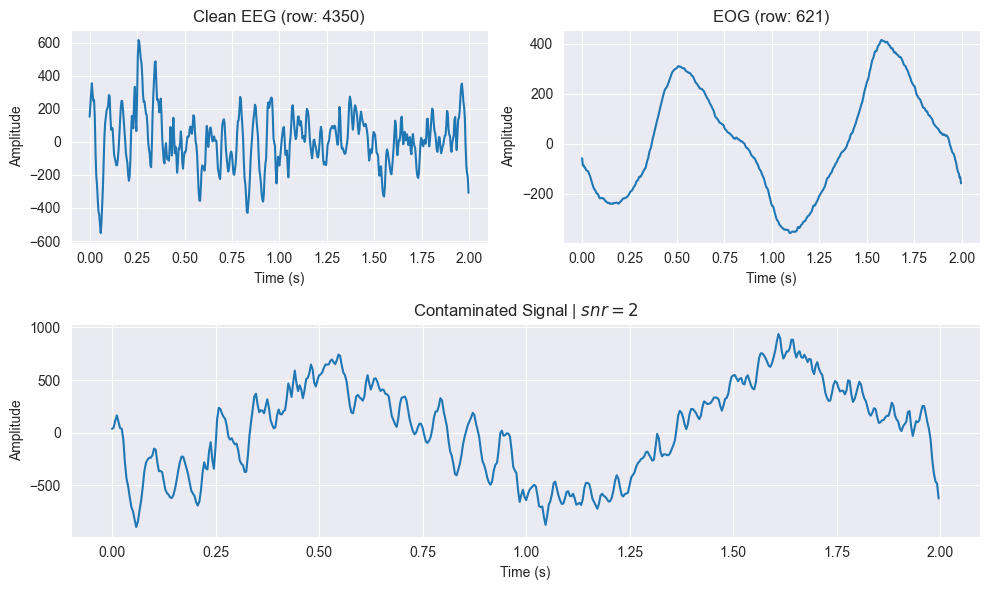

In [8]:
# Print the indices of the clean EEG data and EOG artifacts used for each contaminated signal
#for i, (eeg_index, eog_index) in enumerate(contamination_indices):
#    print(f"Contaminated EEG sample {i+1}: Clean EEG index = {eeg_index}, EOG index = {eog_index}")
#print(contamination_indices)

sampling_rate = 256  # Hz
duration = 2  # seconds
time = np.arange(0, duration, 1/sampling_rate)

plt.figure(figsize=(10, 6))
row=0

# Plot clean EEG
plt.subplot(2, 2, 1)
plt.plot(time, eeg[contamination_indices[row][0]])  # Replace '0' with the desired segment or row from the clean EEG data
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Clean EEG (row: {contamination_indices[row][0]})')

# Plot EOG
plt.subplot(2, 2, 2)
plt.plot(time, eog[contamination_indices[row][1]])  # Replace '0' with the desired segment or row from the EOG data
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'EOG (row: {contamination_indices[row][1]})')

# Plot contaminated signal
plt.subplot(2, 1, 2)
plt.plot(time, contaminated_eeg_data[row])  # Replace '0' with the desired segment or row from the contaminated signal
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Contaminated Signal | $snr={snr_values[row]}$')

plt.tight_layout()
plt.show()

In [41]:
import numpy as np

def calculate_snr(contaminated_signal, clean_eeg, artifact_segment):
    # Calculate the signal power (clean EEG)
    signal_power = np.sum(clean_eeg ** 2)
    # Calculate the noise power (artifact segment)
    noise_power = np.sum((contaminated_signal - clean_eeg) ** 2)
    # Calculate the SNR in dB (RMS FORMULA)
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

def get_random_rows(dataset, num_rows):
    num_total_rows = dataset.shape[0]
    selected_indices = np.random.choice(num_total_rows, size=num_rows, replace=False)
    selected_rows = dataset[selected_indices, :]
    return selected_rows

def calculate_snr(contaminated_eeg_data, clean_eeg_data, artifact_data):
    # Calculate the signal power (clean EEG)
    signal_power = np.sum(clean_eeg_data ** 2, axis=1)
    # Calculate the noise power (artifact segment)
    noise_power = np.sum((contaminated_eeg_data - clean_eeg_data) ** 2, axis=1)
    # Calculate the SNR in dB for each contaminated EEG sample
    snr_db = 10 * np.log10(signal_power / noise_power)

    return snr_db

#----------------
clean_eeg_data = get_random_rows(eeg,1000)
artifact_data = get_random_rows(eog,1000)
λ = 0.3
for i in [4]:
    λ=i
    contaminated_eeg_data = clean_eeg_data + λ * artifact_data
    # Calculate SNR for each contaminated EEG sample
    snr_values = calculate_snr(contaminated_eeg_data, clean_eeg_data, artifact_data)

    # Verify the shape of the SNR values array
    print(f"\n\n-----| {λ} |-----")
    print("Shape of SNR values:", snr_values.shape)
    # Example: print SNR values for the first 10 contaminated EEG samples
    print(f"SNR values for the first 10 samples: {round(snr_values[0]),round(snr_values[1]),round(snr_values[2]),round(snr_values[3]),round(snr_values[4]),round(snr_values[5]),round(snr_values[6]),round(snr_values[7]),round(snr_values[8]),round(snr_values[9])}")
    print(f"Max SNR: {round(max(snr_values))}\nMin SNR: {round(min(snr_values))}\nAverage SNR: {round(np.mean(snr_values))}")



-----| 4 |-----
Shape of SNR values: (1000,)
SNR values for the first 10 samples: (-11, -2, -6, 2, -7, 0, -1, -1, -13, -4)
Max SNR: 11
Min SNR: -25
Average SNR: -6


Ocular artifacts: [-7 to 2] Mygoenic artifact: [-7 to 4]



| λ   | Max | Min | AVG | SNR values of first 10 samples           |
|-----|-----|-----|-----|------------------------------------------|
| 0.1 | 42  | 9   | 26  | (25, 33, 26, 38, 28, 31, 37, 35, 23, 26) |
| 0.2 | 37  | 1   | 20  | (27, 16, 23, 20, 17, 14, 20, 22, 12, 24) |
| 0.3 | 32  | -1  | 17  | (16, 24, 17, 28, 18, 22, 28, 26, 14, 17)                                         |
| 0.4 | 31  | -9  | 14  | (18, 16, 2, 10, 17, 3, 22, 13, 9, 7)     |
| 0.5 | 30  | -7  | 12  | (9, 18, 6, 8, 15, 9, 6, 10, 11, 11)      |
| 0.6 | 26  | -7  | 11  | (10, 18, 11, 22, 12, 16, 22, 20, 8, 11)                                         |
| 0.7 | 25  | -8  | 9   | (8, 16, 9, 21, 11, 14, 20, 18, 6, 9)                                         |
| 0.8 | 24  | -9  | 8   | (7, 15, 8, 20, 10, 13, 19, 17, 5, 8)                                         |
| 0.9 | 23  | -10 | 7   | (6, 14, 7, 19, 9, 12, 18, 16, 4, 7)                                         |
| 1   | 22  | -11 | 6   | (5, 13, 6, 18, 8, 11, 17, 15, 3, 6)                                         |
| 1.1 | 23  | -13 | 5   | (1, 4, -2, 3, -1, 23, -3, 2, 9, 3)                                         |
| 1.2 | 22  | -13 | 4   | (1, 3, -3, 2, -1, 22, -4, 1, 8, 2)                                         |
| 1.3 | 22  | -14 | 4   | (0, 2, -3, 1, -2, 22, -4, 0, 7, 1)                                         |
| 1.4 | 21  | -15 | 3   | (-1, 2, -4, 1, -3, 21, -5, 0, 7, 1)                                         |
| 1.5 | 21  | -15 | 2   | (-1, 1, -5, 0, -3, 21, -6, -1, 6, 0)                                         |
| 1.6 | 20  | -16 | 2   | (-2, 1, -5, 0, -4, 20, -6, -2, 6, 0)                                         |
| 1.7 | 19  | -16 | 1   | (-2, 0, -6, -1, -4, 19, -7, -2, 5, -1)                                         |
| 1.8 | 19  | -17 | 1   | (-3, -1, -6, -1, -5, 19, -7, -3, 5, -1)                                         |
| 1.9 | 18  | -17 | 0   | (-3, -1, -7, -2, -5, 18, -8, -3, 4, -2)                                         |
| 2.0 | 18  | -18 | 0   | (-4, -1, -7, -2, -6, 18, -8, -3, 4, -2)                                         |


In [12]:
# Generate some example data (replace these with your actual data)
num_samples = 1000
num_eeg_channels = 512

clean_eeg_data = get_random_rows(eeg,1000)
artifact_data = get_random_rows(eog,1000)
λ = 0.5


contaminated_eeg_data = clean_eeg_data + λ * artifact_data

# Calculate SNR for each contaminated EEG sample
snr_values = calculate_snr(contaminated_eeg_data, clean_eeg_data, artifact_data)

# Verify the shape of the SNR values array
print("Shape of SNR values:", snr_values.shape)

# Example: print SNR values for the first 10 contaminated EEG samples
print("SNR values for the first 10 samples:")
print(snr_values[:10])

Shape of SNR values: ()
SNR values for the first 10 samples:


IndexError: invalid index to scalar variable.